<a href="https://colab.research.google.com/github/yeon524/TEAM_PROJECT/blob/main/%EB%AC%BC%EB%A5%98_%EC%84%BC%ED%84%B0%EC%A0%9C%EC%95%BD_CPLEX%2BTABU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[A_NoConstraint_Tabu] MILP + Tabu VRP 풀이 시작
  λ = None, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [1, 2, 3]
  DC 1 | Tabu VRP 거리 = 134.39, routes 개수 = 1
  DC 2 | Tabu VRP 거리 = 291.68, routes 개수 = 3
  DC 3 | Tabu VRP 거리 = 151.02, routes 개수 = 2

[A_NoConstraint_Tabu] 결과 요약
  개설된 DC: [1, 2, 3]
  개설비용: 120
  VRP 비용: 577.0965419888757
  총비용: 697.0965419888757


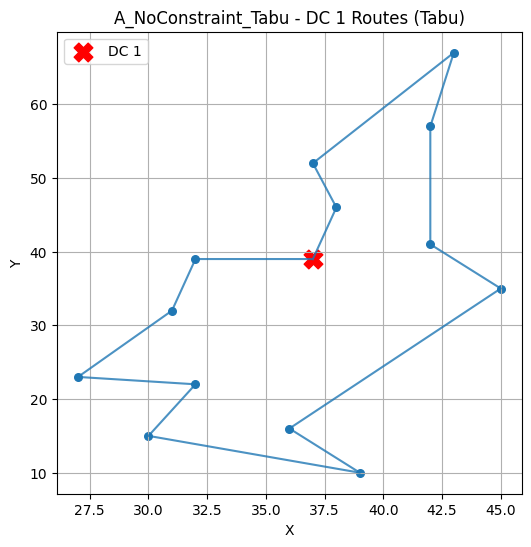

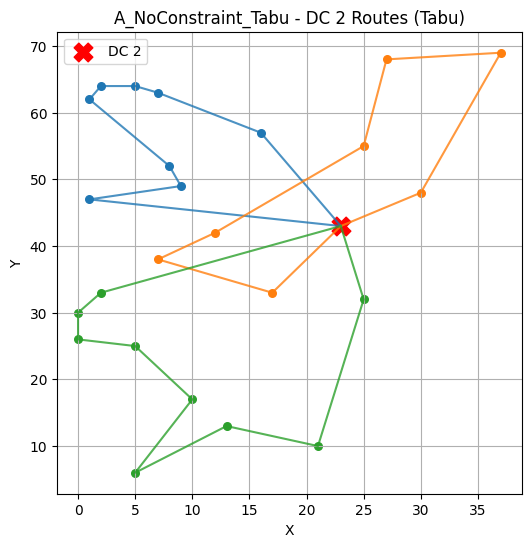

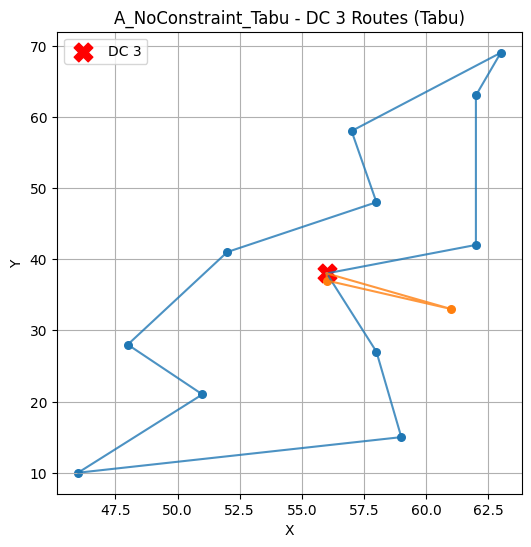


=== B_LambdaOnly — λ grid search (Tabu) ===

[B_LambdaOnly_lam0.1_Tabu] MILP + Tabu VRP 풀이 시작
  λ = 0.1, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.10 → infeasible

[B_LambdaOnly_lam0.15_Tabu] MILP + Tabu VRP 풀이 시작
  λ = 0.15, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.15 → infeasible

[B_LambdaOnly_lam0.2_Tabu] MILP + Tabu VRP 풀이 시작
  λ = 0.2, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Infeasible
 → 최적해를 찾지 못했거나 infeasible 입니다.
  λ=0.20 → infeasible

[B_LambdaOnly_lam0.25_Tabu] MILP + Tabu VRP 풀이 시작
  λ = 0.25, MIN_CUST = None, CAPACITY_CONSTR = True
MILP Status: Optimal
개설된 DC: [0, 1, 2, 3, 4]
  DC 0 | Tabu VRP 거리 = 127.49, routes 개수 = 2
  DC 1 | Tabu VRP 거리 = 137.81, routes 개수 = 2
  DC 2 | Tabu VRP 거리 = 168.98, routes 개수 = 2
  DC 3 | Tabu VRP 거리 = 128.32, routes 개수 = 2
  DC 4 | Tabu VRP 거리 = 67.29, routes 개수 = 1

[B_LambdaOnly_lam0.25_Tabu] 결과 요약
  개설된 DC:

In [3]:
# =========================================================
# Colab 버전 최종 코드 (CPLEX + Tabu, 빡세게 튜닝 버전)
# - MILP: PuLP + CPLEX_PY  → DC 개설/배정 (Facility Location)
# - VRP: Tabu Search 기반 CVRP (트럭 용량 160, depot 복귀)
# - 케이스 A/B/C/D 4개 한 번에 실행
#   * B: λ 자동 탐색
#   * C: min_cust 자동 탐색
#   * D: (λ, min_cust) 그리드 서치
#   * 전부 tabu_iter=1000, tabu_neigh=50으로 “빡세게” 탐색
# =========================================================

!pip install pulp cplex --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import pulp

# ---------------------------------------------
# 0) 데이터 로드
# ---------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index": "Customer_ID"})
dc       = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index": "DC_ID"})
truck    = pd.read_csv("/content/Truck.csv")

C = len(customer)   # 고객 수 (예: 50)
D = len(dc)         # DC 수   (예: 5)

TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])   # 예: 160
open_cost_j    = dc["COST"].values               # DC 개설비용
dc_capacity_j  = dc["CAPACITY"].values           # DC 보관용량

demand        = customer["DEMAND"].values
total_demand  = demand.sum()

cust_coords = [(customer.loc[i, "X"], customer.loc[i, "Y"]) for i in range(C)]
dc_coords   = [(dc.loc[j, "X"],       dc.loc[j, "Y"])       for j in range(D)]

# ---------------------------------------------
# 1) 유틸 (거리)
# ---------------------------------------------
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# ---------------------------------------------
# 2) Tabu Search 기반 CVRP 솔버
# ---------------------------------------------
def compute_route_cost(route, dist_matrix):
    """ route: [0, i1, i2, ..., 0] """
    c = 0.0
    for k in range(len(route)-1):
        c += dist_matrix[route[k]][route[k+1]]
    return c

def compute_total_cost(routes, dist_matrix):
    return sum(compute_route_cost(r, dist_matrix) for r in routes)

def compute_route_demand(route, demands):
    """ route 안 고객 수요 합 (depot=0은 제외) """
    return sum(demands[node] for node in route if node != 0)

def initial_solution_greedy(demands, dist_matrix, vehicle_capacity):
    """
    단순 greedy로 CVRP 초기해 만들기:
    - 고객 순서를 랜덤 섞고,
    - 용량 남는 차량에 순서대로 넣기,
    - 안 들어가면 새 차량 추가
    """
    n = len(demands)  # 0 포함
    customer_ids = list(range(1, n))
    random.shuffle(customer_ids)

    total_demand = sum(demands[1:])
    num_vehicles = max(1, int(np.ceil(total_demand / vehicle_capacity)))

    routes = []
    remaining_cap = []

    for _ in range(num_vehicles):
        routes.append([0, 0])  # depot → depot
        remaining_cap.append(vehicle_capacity)

    for cust in customer_ids:
        d = demands[cust]
        inserted = False
        for r_idx in range(len(routes)):
            if remaining_cap[r_idx] >= d:
                routes[r_idx].insert(-1, cust)
                remaining_cap[r_idx] -= d
                inserted = True
                break
        if not inserted:
            routes.append([0, cust, 0])
            remaining_cap.append(vehicle_capacity - d)

    clean_routes = []
    for r in routes:
        if len(r) > 2:
            clean_routes.append(r)
    if not clean_routes:
        clean_routes = [[0, 0]]

    return clean_routes

def tabu_search_cvrp(demands, dist_matrix, vehicle_capacity,
                     max_iter=400, tabu_tenure=10, neighborhood_size=40,
                     seed=0, verbose=False):
    """
    relocation 기반 Tabu Search CVRP
    - move: 고객 하나를 다른 위치(다른 route 포함)에 재배치
    - 용량 제약 체크
    """
    random.seed(seed)
    np.random.seed(seed)

    current_routes = initial_solution_greedy(demands, dist_matrix, vehicle_capacity)
    current_cost   = compute_total_cost(current_routes, dist_matrix)

    best_routes = copy.deepcopy(current_routes)
    best_cost   = current_cost

    tabu_list = {}

    if verbose:
        print(f"Initial solution: cost={best_cost:.2f}, routes={best_routes}")

    for it in range(max_iter):
        # Tabu decay
        remove_keys = []
        for mv in tabu_list:
            tabu_list[mv] -= 1
            if tabu_list[mv] <= 0:
                remove_keys.append(mv)
        for mv in remove_keys:
            del tabu_list[mv]

        best_neighbor = None
        best_neighbor_cost = float("inf")
        best_move = None

        # neighborhood_size 번 랜덤 move 생성
        for _ in range(neighborhood_size):
            if len(current_routes) == 0:
                break

            r_from = random.randrange(len(current_routes))
            route_from = current_routes[r_from]
            if len(route_from) <= 2:
                continue

            pos_from = random.randrange(1, len(route_from)-1)
            cust = route_from[pos_from]

            r_to = random.randrange(len(current_routes))
            route_to = current_routes[r_to]

            insert_pos = random.randrange(1, len(route_to))

            if r_from == r_to and (insert_pos == pos_from or insert_pos == pos_from+1):
                continue

            new_routes = copy.deepcopy(current_routes)

            new_routes[r_from].pop(pos_from)
            if r_from == r_to:
                if insert_pos > pos_from:
                    insert_pos -= 1
            new_routes[r_to].insert(insert_pos, cust)

            feasible = True
            for rt in new_routes:
                rt_demand = compute_route_demand(rt, demands)
                if rt_demand > vehicle_capacity + 1e-9:
                    feasible = False
                    break
            if not feasible:
                continue

            cleaned_routes = []
            for rt in new_routes:
                if len(rt) > 2:
                    cleaned_routes.append(rt)
            if not cleaned_routes:
                cleaned_routes = [[0, 0]]

            new_cost = compute_total_cost(cleaned_routes, dist_matrix)
            move_id = (cust, r_from, r_to)

            if move_id in tabu_list and new_cost >= best_cost - 1e-9:
                continue

            if new_cost < best_neighbor_cost:
                best_neighbor_cost = new_cost
                best_neighbor = cleaned_routes
                best_move = move_id

        if best_neighbor is None:
            if verbose:
                print(f"[Iter {it}] No feasible neighbor found. Stop.")
            break

        current_routes = best_neighbor
        current_cost   = best_neighbor_cost

        if best_move is not None:
            tabu_list[best_move] = tabu_tenure

        if current_cost < best_cost - 1e-6:
            best_cost = current_cost
            best_routes = copy.deepcopy(current_routes)

        if verbose and (it % 100 == 0 or it == max_iter-1):
            print(f"[Iter {it}] current={current_cost:.2f}, best={best_cost:.2f}")

    return best_cost, best_routes

def solve_vrp_tabu(demands, dist_matrix, vehicle_capacity,
                   max_iter=400, tabu_tenure=10, neighborhood_size=40,
                   time_limit_sec=None, seed=0, verbose=False):
    cost, routes = tabu_search_cvrp(
        demands=demands,
        dist_matrix=dist_matrix,
        vehicle_capacity=vehicle_capacity,
        max_iter=max_iter,
        tabu_tenure=tabu_tenure,
        neighborhood_size=neighborhood_size,
        seed=seed,
        verbose=verbose
    )
    return cost, routes

# ---------------------------------------------
# 3) MILP 모델 생성 (CPLEX 그대로)
# ---------------------------------------------
def build_milp_model(lam=None, min_cust=None, use_capacity=True):
    model = pulp.LpProblem("FacilityLocation_Generic", pulp.LpMinimize)

    y = pulp.LpVariable.dicts("OpenDC", range(D), cat="Binary")
    x = pulp.LpVariable.dicts("Assign", (range(C), range(D)), cat="Binary")

    dist_cost = np.zeros((C, D))
    for i in range(C):
        for j in range(D):
            dist_cost[i, j] = euclid(cust_coords[i], dc_coords[j])

    model += (
        pulp.lpSum([y[j] * open_cost_j[j] for j in range(D)]) +
        pulp.lpSum([x[i][j] * dist_cost[i, j] for i in range(C) for j in range(D)])
    )

    for i in range(C):
        model += pulp.lpSum([x[i][j] for j in range(D)]) == 1

    for i in range(C):
        for j in range(D):
            model += x[i][j] <= y[j]

    if lam is not None:
        max_load = lam * total_demand
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= max_load

    if min_cust is not None:
        for j in range(D):
            model += pulp.lpSum([x[i][j] for i in range(C)]) >= min_cust * y[j]

    if use_capacity:
        for j in range(D):
            model += pulp.lpSum([x[i][j] * demand[i] for i in range(C)]) <= dc_capacity_j[j]

    return model, x, y

# ---------------------------------------------
# 4) MILP + Tabu VRP 통합 실행
# ---------------------------------------------
def solve_milp_and_vrp_tabu(case_name, lam=None, min_cust=None,
                            use_capacity=True,
                            tabu_iter=400, tabu_tenure=10, tabu_neigh=40,
                            cplex_msg=False, do_plot=False):
    print("\n============================")
    print(f"[{case_name}] MILP + Tabu VRP 풀이 시작")
    print(f"  λ = {lam}, MIN_CUST = {min_cust}, CAPACITY_CONSTR = {use_capacity}")
    print("============================")

    model, x, y = build_milp_model(lam=lam, min_cust=min_cust, use_capacity=use_capacity)

    try:
        solver = pulp.CPLEX_PY(msg=cplex_msg)
    except Exception as e:
        raise RuntimeError("CPLEX_PY solver를 사용할 수 없습니다. Colab에서 'pip install cplex'가 성공했는지 확인하세요.") from e

    status = model.solve(solver)
    status_str = pulp.LpStatus[status]
    print("MILP Status:", status_str)
    if status_str != "Optimal":
        print(" → 최적해를 찾지 못했거나 infeasible 입니다.")
        return None

    opened_centers = []
    assignment     = {}

    for j in range(D):
        if y[j].value() > 0.5:
            opened_centers.append(j)

    for i in range(C):
        for j in range(D):
            if x[i][j].value() > 0.5:
                assignment[i] = j
                break

    if len(opened_centers) == 0:
        print(" → 어떤 DC도 열리지 않음 (infeasible 취급)")
        return None

    print("개설된 DC:", opened_centers)

    open_cost_total = sum(open_cost_j[j] for j in opened_centers)

    total_vrp_cost = 0.0
    routes_detail  = {}

    for dc_id in opened_centers:
        cust_list = [i for i in range(C) if assignment[i] == dc_id]
        if not cust_list:
            continue

        locs = []
        dc_row = dc.loc[dc_id]
        locs.append((dc_row["X"], dc_row["Y"]))
        for cid in cust_list:
            crow = customer.loc[cid]
            locs.append((crow["X"], crow["Y"]))

        n = len(locs)
        dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]
        demands_local = [0] + [int(demand[cid]) for cid in cust_list]

        vrp_dist, routes = solve_vrp_tabu(
            demands=demands_local,
            dist_matrix=dist_matrix,
            vehicle_capacity=TRUCK_CAPACITY,
            max_iter=tabu_iter,
            tabu_tenure=tabu_tenure,
            neighborhood_size=tabu_neigh,
            seed=dc_id
        )

        total_vrp_cost += vrp_dist
        routes_detail[dc_id] = {
            "routes": routes,
            "locs":  locs,
            "customers": cust_list
        }

        print(f"  DC {dc_id} | Tabu VRP 거리 = {vrp_dist:.2f}, routes 개수 = {len(routes)}")

    total_cost = open_cost_total + total_vrp_cost

    print(f"\n[{case_name}] 결과 요약")
    print("  개설된 DC:", opened_centers)
    print("  개설비용:", open_cost_total)
    print("  VRP 비용:", total_vrp_cost)
    print("  총비용:", total_cost)

    if do_plot:
        for dc_id in opened_centers:
            detail = routes_detail[dc_id]
            routes = detail["routes"]
            locs   = detail["locs"]

            plt.figure(figsize=(6,6))
            x_dc, y_dc = locs[0]
            plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

            colors = ["tab:blue", "tab:orange", "tab:green", "tab:red",
                      "tab:purple", "tab:brown", "tab:pink", "tab:gray"]
            for r_idx, route in enumerate(routes):
                xs, ys = [], []
                for node in route:
                    x, y = locs[node]
                    xs.append(x); ys.append(y)
                    if node != 0:
                        plt.scatter(x, y, c=colors[r_idx % len(colors)], s=30)
                plt.plot(xs, ys, c=colors[r_idx % len(colors)], alpha=0.8)

            plt.title(f"{case_name} - DC {dc_id} Routes (Tabu)")
            plt.xlabel("X"); plt.ylabel("Y")
            plt.grid(True); plt.legend()
            plt.show()

    result = {
        "case": case_name,
        "lambda": lam,
        "min_cust": min_cust,
        "opened": opened_centers,
        "open_cost": open_cost_total,
        "vrp_cost": total_vrp_cost,
        "total_cost": total_cost,
        "routes_detail": routes_detail,
        "assignment": assignment
    }
    return result

# ---------------------------------------------
# 5) λ / min_cust 후보 자동 생성
# ---------------------------------------------
def lambda_candidates():
    return [round(0.10 + 0.05 * k, 2) for k in range(0, 17)]

def min_cust_candidates():
    step = max(1, C // 10)
    max_val = max(step, C // 2)
    return list(range(step, max_val + 1, step))

# ---------------------------------------------
# 6) 4가지 케이스 한 번에 실행 (전부 빡세게)
# ---------------------------------------------
results_all = {}

# 공통 세팅 (빡세게)
TABU_ITER  = 1000
TABU_TENURE = 10
TABU_NEIGH = 50

# A. 제약 없음
results_all["A_None"] = solve_milp_and_vrp_tabu(
    case_name="A_NoConstraint_Tabu",
    lam=None,
    min_cust=None,
    use_capacity=True,
    tabu_iter=TABU_ITER, tabu_tenure=TABU_TENURE, tabu_neigh=TABU_NEIGH,
    do_plot=True
)

# B. 제약 1만 (λ)
print("\n=== B_LambdaOnly — λ grid search (Tabu) ===")
best_B = None
for lam in lambda_candidates():
    res = solve_milp_and_vrp_tabu(
        case_name=f"B_LambdaOnly_lam{lam}_Tabu",
        lam=lam,
        min_cust=None,
        use_capacity=True,
        tabu_iter=TABU_ITER, tabu_tenure=TABU_TENURE, tabu_neigh=TABU_NEIGH,
        do_plot=False
    )
    if res is None:
        print(f"  λ={lam:.2f} → infeasible")
        continue
    print(f"  λ={lam:.2f} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
    if (best_B is None) or (res["total_cost"] < best_B["total_cost"]):
        best_B = res
results_all["B_LambdaOnly"] = best_B

# C. 제약 2만 (MIN_CUST)
print("\n=== C_MinCustOnly — min_cust grid search (Tabu) ===")
best_C = None
for mc in min_cust_candidates():
    res = solve_milp_and_vrp_tabu(
        case_name=f"C_MinCustOnly_mc{mc}_Tabu",
        lam=None,
        min_cust=mc,
        use_capacity=True,
        tabu_iter=TABU_ITER, tabu_tenure=TABU_TENURE, tabu_neigh=TABU_NEIGH,
        do_plot=False
    )
    if res is None:
        print(f"  min_cust={mc} → infeasible")
        continue
    print(f"  min_cust={mc} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
    if (best_C is None) or (res["total_cost"] < best_C["total_cost"]):
        best_C = res
results_all["C_MinCustOnly"] = best_C

# D. 제약 1+2 동시 적용
print("\n=== D_Both — (λ, min_cust) grid search (Tabu) ===")
best_D = None
for lam in lambda_candidates():
    for mc in min_cust_candidates():
        res = solve_milp_and_vrp_tabu(
            case_name=f"D_Both_lam{lam}_mc{mc}_Tabu",
            lam=lam,
            min_cust=mc,
            use_capacity=True,
            tabu_iter=TABU_ITER, tabu_tenure=TABU_TENURE, tabu_neigh=TABU_NEIGH,
            do_plot=False
        )
        if res is None:
            print(f"  λ={lam:.2f}, min_cust={mc} → infeasible")
            continue
        print(f"  λ={lam:.2f}, min_cust={mc} → TOTAL={res['total_cost']:.2f}, opened={res['opened']}")
        if (best_D is None) or (res["total_cost"] < best_D["total_cost"]):
            best_D = res
results_all["D_Both"] = best_D

# ---------------------------------------------
# 7) 최종 비교 출력
# ---------------------------------------------
print("\n================ 최종 비교 (CPLEX + Tabu, 빡세게) ================")
for k, res in results_all.items():
    if res is None:
        print(k, "→ infeasible or failed")
    else:
        print(
            f"{k}: TOTAL={res['total_cost']:.2f}, opened={res['opened']}, "
            f"λ={res['lambda']}, min_cust={res['min_cust']}"
        )
print("=========================================================")


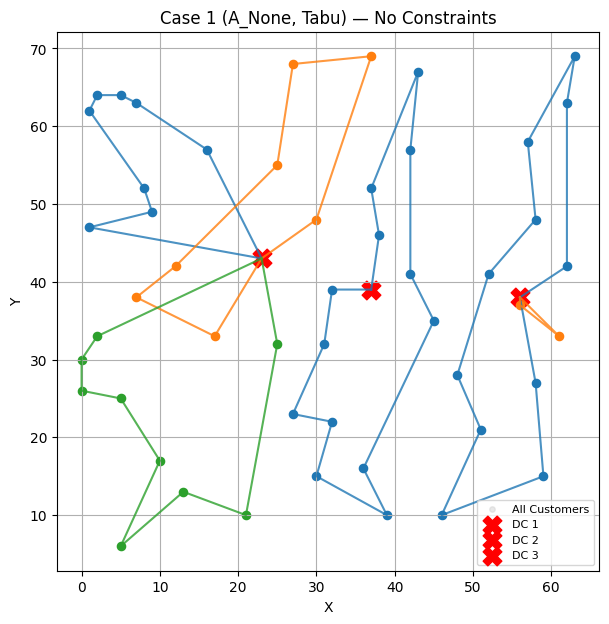

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


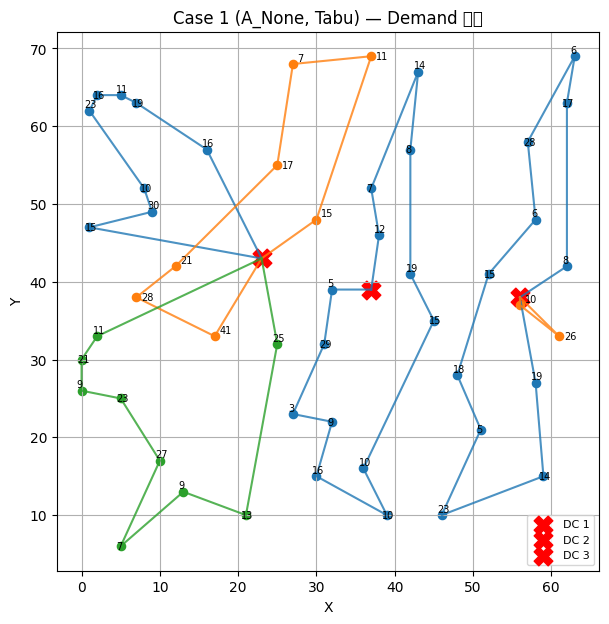

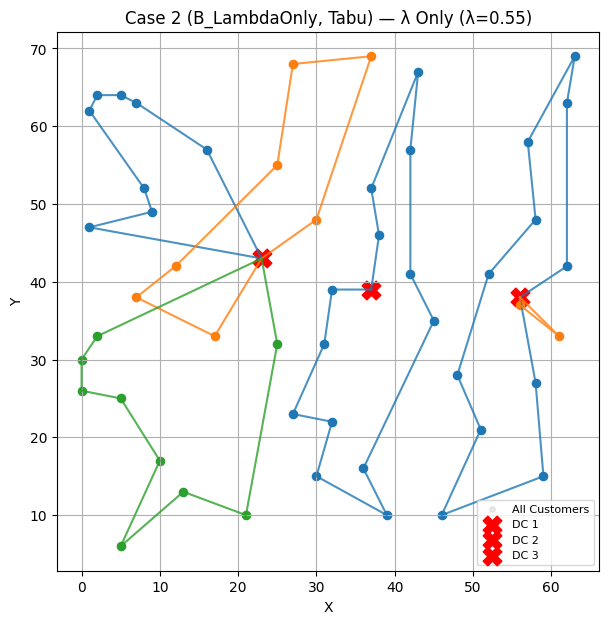

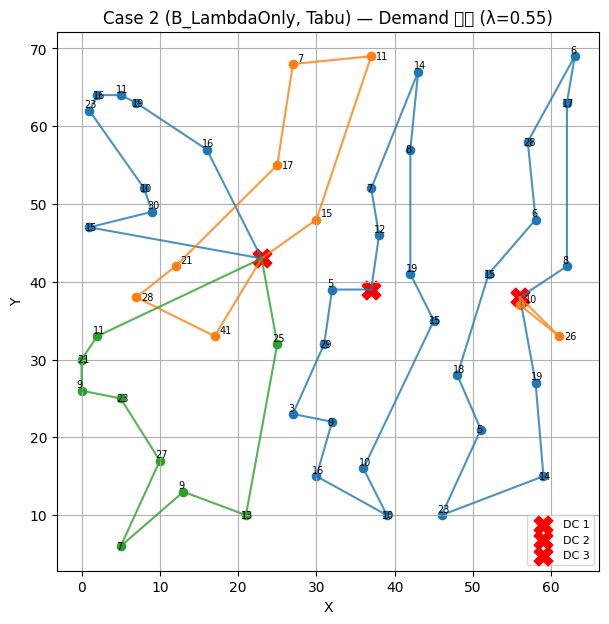

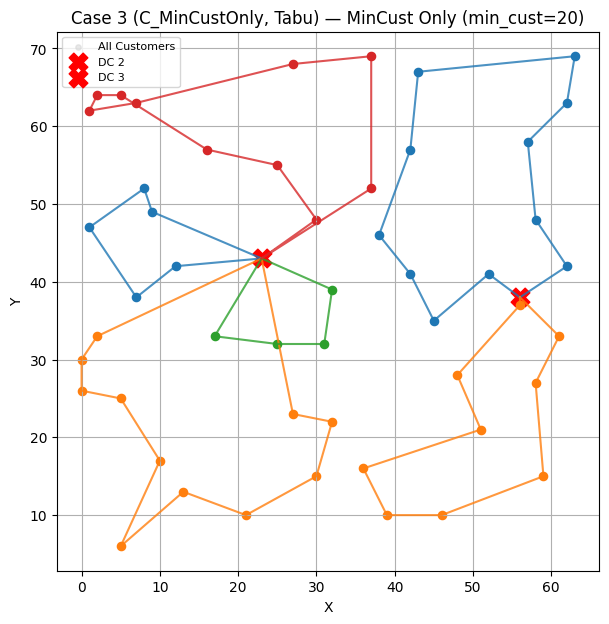

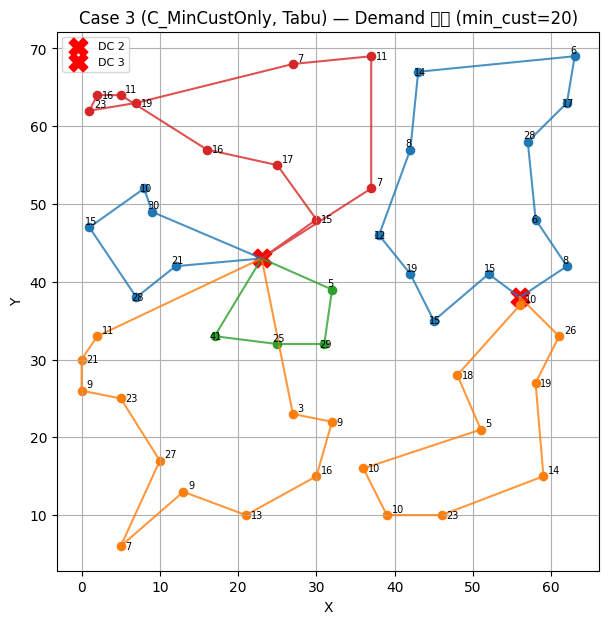

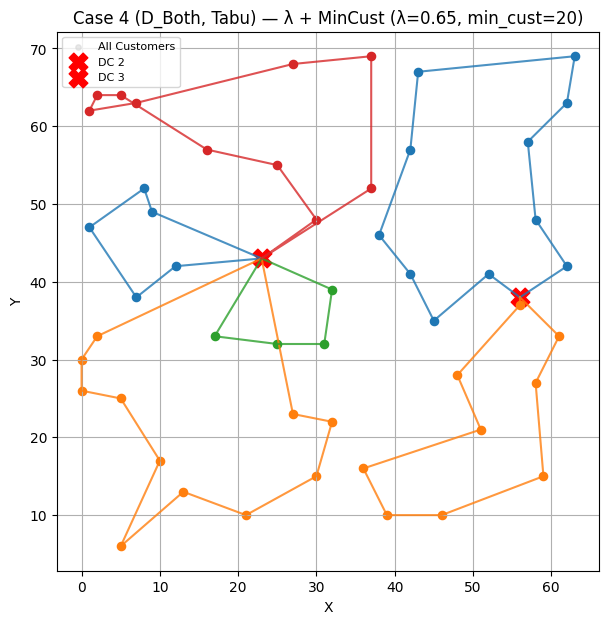

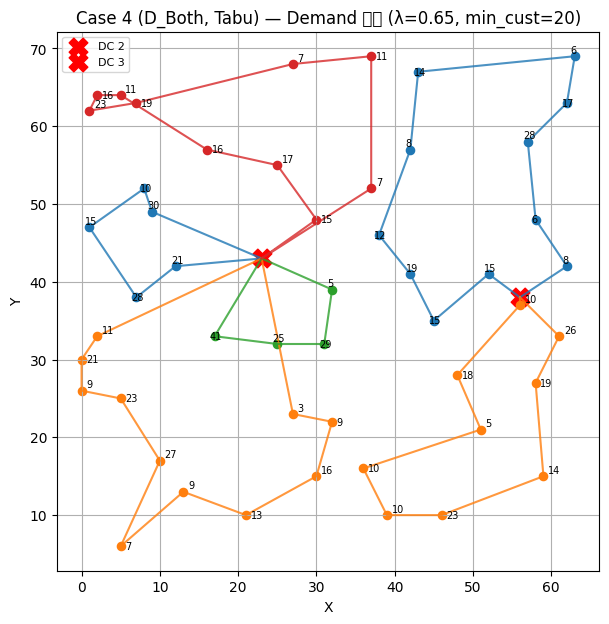

In [4]:
# ============================================================
# (추가) CPLEX + Tabu 결과 시각화 함수들
#   - DC별 route를 한 그림에
#   - demand 숫자 표시 버전도 포함
# ============================================================
import matplotlib.pyplot as plt

# 색상 팔레트 (트럭/route별로 색 다르게)
ROUTE_COLORS = [
    "tab:blue", "tab:orange", "tab:green", "tab:red",
    "tab:purple", "tab:brown", "tab:pink", "tab:gray",
    "tab:olive", "tab:cyan"
]

def plot_case_all_dc_tabu(result, title=""):
    """CPLEX + Tabu 결과: 경로만 보는 기본 버전"""
    if result is None:
        print(f"[{title}] 결과가 없습니다 (infeasible or failed).")
        return

    routes_detail = result["routes_detail"]
    opened        = result["opened"]

    plt.figure(figsize=(7, 7))

    # 전체 고객 위치를 옅은 점으로 표시
    plt.scatter(customer["X"], customer["Y"],
                c="lightgray", s=15, alpha=0.5, label="All Customers")

    for dc_id in opened:
        detail = routes_detail[dc_id]
        routes = detail["routes"]
        locs   = detail["locs"]   # 0: DC, 1~: 그 DC가 담당하는 고객

        # DC 표시
        x_dc, y_dc = locs[0]
        plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

        # 각 트럭 route마다 색 다르게
        for r_idx, route in enumerate(routes):
            color = ROUTE_COLORS[r_idx % len(ROUTE_COLORS)]
            xs, ys = [], []
            for node in route:
                x, y = locs[node]
                xs.append(x); ys.append(y)
                if node != 0:
                    plt.scatter(x, y, c=color, s=35)
            plt.plot(xs, ys, c=color, alpha=0.8)

    plt.title(title)
    plt.xlabel("X"); plt.ylabel("Y")
    plt.grid(True)

    # 중복 레이블 제거
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=8)

    plt.show()


def plot_case_all_dc_with_demand_tabu(result, title=""):
    """CPLEX + Tabu 결과: 고객 옆에 demand 숫자까지 표시하는 버전"""
    if result is None:
        print(f"[{title}] 결과가 없습니다 (infeasible or failed).")
        return

    routes_detail = result["routes_detail"]
    opened        = result["opened"]

    plt.figure(figsize=(7, 7))

    # 전체 고객 위치 (연한 점)
    plt.scatter(customer["X"], customer["Y"],
                c="lightgray", s=15, alpha=0.4)

    for dc_id in opened:
        detail = routes_detail[dc_id]
        routes = detail["routes"]
        locs   = detail["locs"]
        cust_ids = detail["customers"]  # global index 리스트

        # DC 표시
        x_dc, y_dc = locs[0]
        plt.scatter(x_dc, y_dc, c="red", marker="X", s=180, label=f"DC {dc_id}")

        for r_idx, route in enumerate(routes):
            color = ROUTE_COLORS[r_idx % len(ROUTE_COLORS)]
            xs, ys = [], []
            for pos, node in enumerate(route):
                x, y = locs[node]
                xs.append(x); ys.append(y)

                if node != 0:
                    plt.scatter(x, y, c=color, s=35)

                    # node==1 → customers[0], node==2 → customers[1] ...
                    global_index = cust_ids[node-1]
                    d = int(customer.loc[global_index, "DEMAND"])

                    # 라벨이 너무 겹치지 않도록 route/pos에 따라 약간씩 방향 바꾸기
                    dx = 0.6 * ((r_idx % 2) * 2 - 1)   # +0.6 또는 -0.6
                    dy = 0.4 * ((pos % 2) * 2 - 1)    # +0.4 또는 -0.4
                    plt.text(x + dx, y + dy,
                             f"{d}", fontsize=7, color="black")

            plt.plot(xs, ys, c=color, alpha=0.8)

    plt.title(title)
    plt.xlabel("X"); plt.ylabel("Y")
    plt.grid(True)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=8)

    plt.show()


# ============================================================
# 4개 케이스 각각 2장씩 시각화 호출 (기본 + demand 표시)
# ============================================================

# ---- Case 1 ----
plot_case_all_dc_tabu(
    results_all["A_None"],
    title="Case 1 (A_None, Tabu) — No Constraints"
)
plot_case_all_dc_with_demand_tabu(
    results_all["A_None"],
    title="Case 1 (A_None, Tabu) — Demand 표시"
)

# ---- Case 2 ----
plot_case_all_dc_tabu(
    results_all["B_LambdaOnly"],
    title=f"Case 2 (B_LambdaOnly, Tabu) — λ Only (λ={results_all['B_LambdaOnly']['lambda']})"
)
plot_case_all_dc_with_demand_tabu(
    results_all["B_LambdaOnly"],
    title=f"Case 2 (B_LambdaOnly, Tabu) — Demand 표시 (λ={results_all['B_LambdaOnly']['lambda']})"
)

# ---- Case 3 ----
plot_case_all_dc_tabu(
    results_all["C_MinCustOnly"],
    title=f"Case 3 (C_MinCustOnly, Tabu) — MinCust Only (min_cust={results_all['C_MinCustOnly']['min_cust']})"
)
plot_case_all_dc_with_demand_tabu(
    results_all["C_MinCustOnly"],
    title=f"Case 3 (C_MinCustOnly, Tabu) — Demand 표시 (min_cust={results_all['C_MinCustOnly']['min_cust']})"
)

# ---- Case 4 ----
plot_case_all_dc_tabu(
    results_all["D_Both"],
    title=f"Case 4 (D_Both, Tabu) — λ + MinCust (λ={results_all['D_Both']['lambda']}, min_cust={results_all['D_Both']['min_cust']})"
)
plot_case_all_dc_with_demand_tabu(
    results_all["D_Both"],
    title=f"Case 4 (D_Both, Tabu) — Demand 표시 (λ={results_all['D_Both']['lambda']}, min_cust={results_all['D_Both']['min_cust']})"
)
